# Example notebook for the ATOM pipeline
---------------------------------

Download the Australian weather dataset from kaggle at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package.  
  
**Description:** Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow.

In [2]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

# Load the Australian weather dataset
X = pd.read_csv('weatherAUS.csv')
X = X.drop(['RISK_MM', 'Date'], axis=1)  # Drop unrelated features

In [3]:
# Call ATOM using only a percentage of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, target="RainTomorrow", percentage=10, verbose=3)

<<=============== ATOM ===============>>
Initial data cleaning...
 --> Dropping 45 duplicate rows.
Algorithm task: binary classification.

Data stats =====================>
Number of features: 21
Number of instances: 14214
Size of training set: 9949
Size of test set: 4265
Instances per target class:
RainTomorrow --> Count
0: No        --> 11100
1: Yes       --> 3114



In [4]:
# Impute missing values
atom.impute(strat_num='mean', strat_cat='remove', max_frac=0.8)

Handling missing values...
 --> Imputing 54 values with mean in feature MinTemp.
 --> Imputing 18 values with mean in feature MaxTemp.
 --> Imputing 119 values with mean in feature Rainfall.
 --> Imputing 4268 values with mean in feature Evaporation.
 --> Imputing 4751 values with mean in feature Sunshine.
 --> Removing 643 rows due to missing values in feature WindGustDir.
 --> Removing 535 rows due to missing values in feature WindDir9am.
 --> Removing 49 rows due to missing values in feature WindDir3pm.
 --> Imputing 81 values with mean in feature Humidity9am.
 --> Imputing 101 values with mean in feature Humidity3pm.
 --> Imputing 615 values with mean in feature Pressure9am.
 --> Imputing 610 values with mean in feature Pressure3pm.
 --> Imputing 3262 values with mean in feature Cloud9am.
 --> Imputing 3390 values with mean in feature Cloud3pm.
 --> Imputing 28 values with mean in feature Temp9am.
 --> Imputing 51 values with mean in feature Temp3pm.
 --> Removing 87 rows due to mi

In [5]:
# Encode the categroical features
atom.encode(max_onehot=10)

Encoding categorical features...
 --> Target-encoding feature Location. Contains 47 unique categories.
 --> Target-encoding feature WindGustDir. Contains 16 unique categories.
 --> Target-encoding feature WindDir9am. Contains 16 unique categories.
 --> Target-encoding feature WindDir3pm. Contains 16 unique categories.
 --> Label-encoding feature RainToday. Contains 2 unique categories.


In [6]:
# Select only the best 10 features
atom.feature_selection(strategy="univariate", max_features=10, max_correlation=0.8)

# See which features were removed due to collinearity
atom.collinear

Performing feature selection...
 --> Feature Pressure3pm was removed due to collinearity with another feature.
 --> Feature Temp9am was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature Location was removed after the univariate test (score: 351.59  p-value: 0.00).
 --> Feature MinTemp was removed after the univariate test (score: 67.19  p-value: 0.00).
 --> Feature MaxTemp was removed after the univariate test (score: 370.92  p-value: 0.00).
 --> Feature Evaporation was removed after the univariate test (score: 113.15  p-value: 0.00).
 --> Feature WindGustDir was removed after the univariate test (score: 186.94  p-value: 0.00).
 --> Feature WindDir9am was removed after the univariate test (score: 208.29  p-value: 0.00).
 --> Feature WindDir3pm was removed after the univariate test (score: 141.64  p-value: 0.00).
 --> Feature WindSpeed9am was removed after the univariate test (score: 128.31  p-value:

,drop_feature,correlated_feature,correlation_value
0,Pressure3pm,Pressure9am,0.95986
1,Temp9am,"MinTemp, MaxTemp","0.89719, 0.88909"
2,Temp3pm,"MaxTemp, Temp9am","0.97747, 0.86395"


In [7]:
# Perform undersampling of the majority class to balance the dataset
atom.balance(undersample=0.8)

Using TensorFlow backend.


Performing undersampling...
 --> Removing 4570 rows from majority class.


In [8]:
# Remove outliers from the training set
atom.outliers(max_sigma=5)

Handling outliers...
 --> Dropping 22 rows due to outliers.


In [9]:
# Change the verbosity of ATOM to not print too much details while fitting
atom.verbose = 1

# Fit using successive halving on tree-based models
atom.fit(['tree', 'bag', 'et', 'rf', 'adab', 'gbm', 'lgb', 'catb'],
        successive_halving=True,
        metric='f1',
        max_iter=5,
        init_points=1,
        cv=1,
        bagging=5)


Running pipeline =================>


<<================ Iteration 0 ================>>
Models in pipeline: Tree, Bag, ET, RF, AdaB, GBM, LGB, CatB


Processing: 100%|████████████████████████████████| 8/8 [00:26<00:00,  3.36s/it]




Final results ================>>
Duration: 00h:00m:26s
Target metric: F1
--------------------------------
Decision Tree             --> 0.572 ± 0.043
Bagging                   --> 0.608 ± 0.017
Extra-Trees               --> 0.605 ± 0.034
Random Forest             --> 0.648 ± 0.024 !!
AdaBoost                  --> 0.591 ± 0.031
Gradient Boosting Machine --> 0.594 ± 0.025
LightGBM                  --> 0.640 ± 0.012
CatBoost                  --> 0.636 ± 0.032


<<================ Iteration 1 ================>>
Models in pipeline: Bag, RF, LGB, CatB


Processing: 100%|████████████████████████████████| 4/4 [00:20<00:00,  5.23s/it]




Final results ================>>
Duration: 00h:00m:47s
Target metric: F1
--------------------------------
Bagging       --> 0.631 ± 0.006
Random Forest --> 0.638 ± 0.008 !!
LightGBM      --> 0.633 ± 0.012
CatBoost      --> 0.625 ± 0.016


<<================ Iteration 2 ================>>
Models in pipeline: RF, LGB


Processing: 100%|████████████████████████████████| 2/2 [00:05<00:00,  2.69s/it]




Final results ================>>
Duration: 00h:00m:53s
Target metric: F1
--------------------------------
Random Forest --> 0.663 ± 0.016
LightGBM      --> 0.665 ± 0.013 !!


<<================ Iteration 3 ================>>
Model in pipeline: LGB


Processing: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]




Final results ================>>
Duration: 00h:00m:55s
Target metric: F1
--------------------------------
LightGBM --> 0.681 ± 0.009


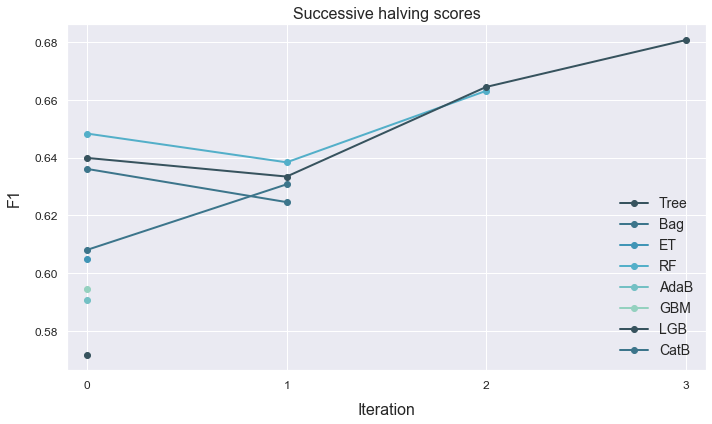

In [11]:
atom.plot_successive_halving()

In [12]:
# Check scores of the first iteration
atom.results[0]

,model,F1,time,bagging_mean,bagging_std,bagging_time
0,Tree,0.625698,0.38s,0.571739,0.043334,0.02s
1,Bag,0.638298,3.88s,0.608048,0.017305,2.02s
2,ET,0.588235,3.35s,0.604817,0.033942,0.38s
3,RF,0.607143,2.44s,0.648362,0.024357,0.93s
4,AdaB,0.596273,2.91s,0.590568,0.031324,0.43s
5,GBM,0.571429,3.06s,0.594324,0.025304,0.85s
6,LGB,0.636872,1.08s,0.639921,0.012365,0.15s
7,CatB,0.644444,4.62s,0.636102,0.031630,0.35s


### LightGBM proved to be the best. Let's have a look at the model!

In [16]:
# Check the winner out
print('Best score: ', atom.lgb.score)
atom.lgb.best_model

Best score:  0.6901217861975644


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=1.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

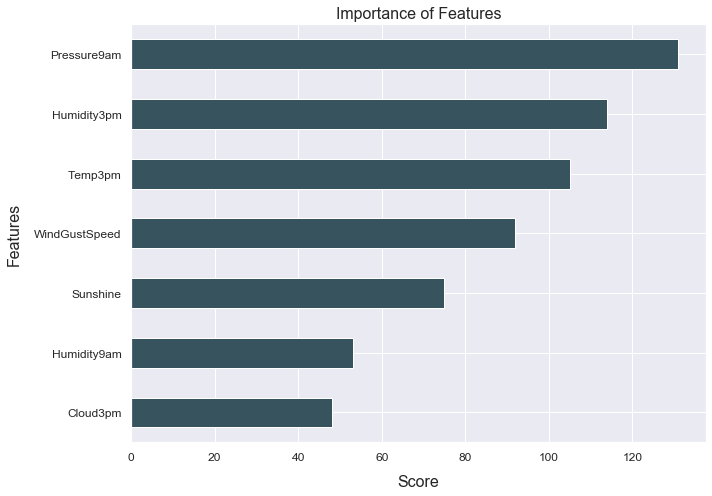

In [17]:
# See feature importance
atom.lgb.plot_feature_importance(show=7, figsize=(10,7))